### Udacity Data Science Nanodegree
### Project 3: Disaster Recovery Pipeline
---

# Notebook 2 of 2: ML Pipeline Preparation

## by Juanita Smith


- [Import libraries and load data from database](#load)
- [Step 1: Data Gathering](#datagathering)
- [Step 2: Assessing](#assessing)
   - [Summary of assessment](#summary_of_assessment)
- [Step 3: Data Cleaning](#clean)
- [Step 4: Save cleaned data](#save)
- [Summary](#summary)
- [References](#references)
- [Submission](#submission)

<a class="anchor" id='load'></a>
<span style="color:blue; font-size:25px; line-height:30px; font-family: Calibri;">1. Import libraries and load data from database</span>

In [1]:
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [114]:
# import libraries
import pandas as pd

import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import re

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import make_scorer, precision_score
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from shutil import rmtree

# save and load models
from pickle import dump

# clear the garbage to free memory as we are working with huge datasets
import gc

from openai import OpenAI
import tiktoken
from typing import List
from ast import literal_eval

# CUSTOM models and functions
from src.startingverbtransformer import StartingVerbExtractor
from src.mloversampler import MLOverSampling
from src import config
from src.utils import *

from wordcloud import WordCloud
from collections import Counter
from time import time

import optuna
import optuna.logging
from optuna.samplers import TPESampler
optuna.logging.disable_default_handler()

# environment settings
pd.set_option('display.max_column', 400)
pd.set_option('display.max_colwidth', 400)
pd.set_option("display.precision", 300)

In [3]:
# default parameters
random_state = 10
xgb.set_config(verbosity=2)

In [4]:
# load cleaned message data from database
engine = create_engine(config.path_database)
conn = engine.connect()
df = pd.read_sql('select * from messages', con=conn, index_col='id')
df.head()

,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,Weather update - a cold front from Cuba that could pass over Haiti,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Is the Hurricane over or is it not over,direct,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
8,Looking for someone but no name,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.,direct,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
12,"says: west side of Haiti, rest of the country today and tonight",direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26179 entries, 2 to 30265
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   message                 26179 non-null  object
 1   genre                   26179 non-null  object
 2   related                 26179 non-null  int64 
 3   request                 26179 non-null  int64 
 4   offer                   26179 non-null  int64 
 5   aid_related             26179 non-null  int64 
 6   medical_help            26179 non-null  int64 
 7   medical_products        26179 non-null  int64 
 8   search_and_rescue       26179 non-null  int64 
 9   security                26179 non-null  int64 
 10  military                26179 non-null  int64 
 11  water                   26179 non-null  int64 
 12  food                    26179 non-null  int64 
 13  shelter                 26179 non-null  int64 
 14  clothing                26179 non-null  int64 
 15  money  

In [6]:
# sqlite does not keep data types int8 or category as it's not supported, set it again
df["genre"] = df["genre"].astype("category")
d = dict.fromkeys(df.select_dtypes(np.int64).columns, np.int8)
df = df.astype(d)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26179 entries, 2 to 30265
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   message                 26179 non-null  object  
 1   genre                   26179 non-null  category
 2   related                 26179 non-null  int8    
 3   request                 26179 non-null  int8    
 4   offer                   26179 non-null  int8    
 5   aid_related             26179 non-null  int8    
 6   medical_help            26179 non-null  int8    
 7   medical_products        26179 non-null  int8    
 8   search_and_rescue       26179 non-null  int8    
 9   security                26179 non-null  int8    
 10  military                26179 non-null  int8    
 11  water                   26179 non-null  int8    
 12  food                    26179 non-null  int8    
 13  shelter                 26179 non-null  int8    
 14  clothing                261

In [7]:
# read message language detection and translation to English, if it exists
df_language = pd.DataFrame()
try:
    df_language = pd.read_sql('select * from message_language',
                              con=conn,
                              index_col='id',
                              dtype={'is_english': 'boolean'}
                              )
finally:
    pass

# df_language[df_language['is_english'] == False].sample(5)
df_language.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7400 entries, 7976 to 369
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   is_english   7400 non-null   boolean
 1   translation  7400 non-null   object 
dtypes: boolean(1), object(1)
memory usage: 130.1+ KB


In [8]:
# merge dataframes
if len(df_language) > 0:
    df = df.merge(df_language, on='id', how='left' )
    
df.head()

,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,is_english,translation
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,Weather update - a cold front from Cuba that could pass over Haiti,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,
7,Is the Hurricane over or is it not over,direct,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,True,
8,Looking for someone but no name,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,
9,UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.,direct,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,True,
12,"says: west side of Haiti, rest of the country today and tonight",direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,


In [9]:
df.tail()

,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,is_english,translation
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
30261,"The training demonstrated how to enhance micronutrient, protein and energy intake for meals using locally grown horticulture produce, rice and fish.",news,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,NaN
30262,A suitable candidate has been selected and OCHA Jakarta is currently working on her three month-contract starting on the 01st July 2005.,news,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,NaN
30263,"Proshika, operating in Cox's Bazar municipality and 5 other unions, Ramu and Chokoria, assessment, 5 kg rice, 1,5 kg lentils to 700 families.",news,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,NaN
30264,"Some 2,000 women protesting against the conduct of the elections were teargassed as they tried to converge on the local electoral commission offices in the southern oil city of Port Harcourt.",news,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,NaN
30265,"A radical shift in thinking came about as a result of this meeting, recognizing that HIV/AIDS is at the core of the humanitarian crisis and identifying the crisis itself as a function of the HIV/AIDS pandemic.",news,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,NaN


In [10]:
# For messages with no translation or language detection, set is_english = True
df['is_english'] = np.where(df['is_english'].isnull(), True, df['is_english'])
df[df['is_english'] == False][:5]


,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,is_english,translation
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
176,"in what field would you need me to speak creole. French, half english, ( MW? )",direct,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,"In what field would you need me to speak Creole, French, half English?"
342,"Onere and some food. Thanks for your understanding. ( Translator's note : are we getting the full messages? Most of them appear to be bits of sentences, like this one )",direct,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,False,"I need some food. Thanks for your understanding. (Translator's note: are we getting the full messages? Most of them appear to be bits of sentences, like this one)"
383,K aTIS RAP CREOLE. CONTACT ME FAST. FAST VIA SMS OR CALL URGENT it is very very important because it today im gonna do wats I got to do over the bariers am allready waiting,direct,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,"I need help in Creole. Contact me quickly, quickly via SMS or call, it's urgent. It is very important because today I'm going to do what I have to do over the barriers, I'm already waiting."
399,Don't know what to do about estaff touterene part at the end,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,Don't know what to do about the staff routing part at the end
508,We are desperate for food and water. Our organization is Kole Zepol pou'n delivre,direct,1,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,We are desperate for food and water. Our organization is Kole Zepol to deliver


In [11]:
# replace message with translation, if message is flagged as not being in English
df['message_new'] =  np.where((df['is_english'] == False) & (~df['translation'].isnull()),
                              df['translation'],
                              df['message'])

In [12]:
# make sure messages already in English are untouched
df[df['is_english'] == True].sample(5)

,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,is_english,translation,message_new
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17292,"According to a local report, one Red Cross worker took three days to drive 100 km from his branch to the regional capital of Hohot because of drifting snow.",news,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,True,NaN,"According to a local report, one Red Cross worker took three days to drive 100 km from his branch to the regional capital of Hohot because of drifting snow."
4742,WHEN SCHOOL GOING TE BE REOPEN,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,,WHEN SCHOOL GOING TE BE REOPEN
25725,"Japanese and US experts are currently investigating high arsenic levels in major cities in the Punjab, including Lahore and Faisalabad, the provinces' second largest city with a population of 2.6 million people.",news,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,NaN,"Japanese and US experts are currently investigating high arsenic levels in major cities in the Punjab, including Lahore and Faisalabad, the provinces' second largest city with a population of 2.6 million people."
2911,Thank you for receiving me. I am traumatized and I am living with much stress. Please help.,direct,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,True,,Thank you for receiving me. I am traumatized and I am living with much stress. Please help.
1481,"RONALD. CEFECAC is a community centre in Raison, it's there every one is. evening times/night times people sleep here. There is a problem with food. tents. sanitary towels/tampons. 5 people are sick. their feet are injured",direct,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,,"RONALD. CEFECAC is a community centre in Raison, it's there every one is. evening times/night times people sleep here. There is a problem with food. tents. sanitary towels/tampons. 5 people are sick. their feet are injured"


In [13]:
# check that messages not in English were replaced
df[df['is_english'] == False][:5]

,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,is_english,translation,message_new
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
176,"in what field would you need me to speak creole. French, half english, ( MW? )",direct,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,"In what field would you need me to speak Creole, French, half English?","In what field would you need me to speak Creole, French, half English?"
342,"Onere and some food. Thanks for your understanding. ( Translator's note : are we getting the full messages? Most of them appear to be bits of sentences, like this one )",direct,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,False,"I need some food. Thanks for your understanding. (Translator's note: are we getting the full messages? Most of them appear to be bits of sentences, like this one)","I need some food. Thanks for your understanding. (Translator's note: are we getting the full messages? Most of them appear to be bits of sentences, like this one)"
383,K aTIS RAP CREOLE. CONTACT ME FAST. FAST VIA SMS OR CALL URGENT it is very very important because it today im gonna do wats I got to do over the bariers am allready waiting,direct,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,"I need help in Creole. Contact me quickly, quickly via SMS or call, it's urgent. It is very important because today I'm going to do what I have to do over the barriers, I'm already waiting.","I need help in Creole. Contact me quickly, quickly via SMS or call, it's urgent. It is very important because today I'm going to do what I have to do over the barriers, I'm already waiting."
399,Don't know what to do about estaff touterene part at the end,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,Don't know what to do about the staff routing part at the end,Don't know what to do about the staff routing part at the end
508,We are desperate for food and water. Our organization is Kole Zepol pou'n delivre,direct,1,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,We are desperate for food and water. Our organization is Kole Zepol to deliver,We are desperate for food and water. Our organization is Kole Zepol to deliver


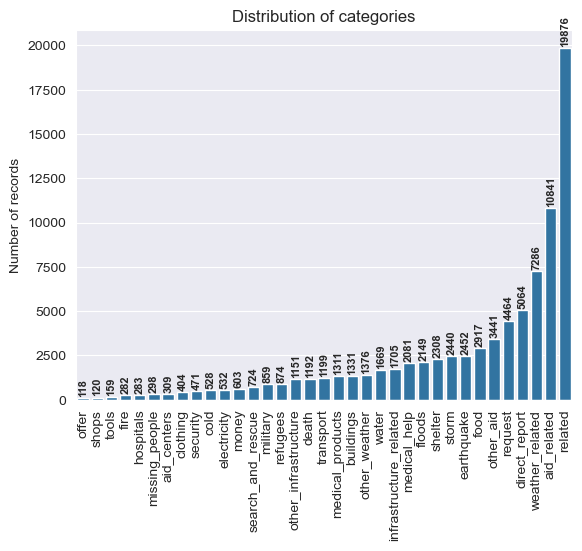

In [14]:
 # plot how categories are distributed
df_sum = df.sum(numeric_only=True).sort_values(ascending=True)
ax = sns.barplot(data=df_sum)

# annotate
for c in ax.containers:
    # set the bar label based on the y-axis
    ax.bar_label(c, padding=1, fontsize=8, rotation=90, weight='bold')
        
plt.xticks(rotation=90)

plt.title('Distribution of categories')
plt.ylabel('Number of records')
plt.show()

## Prepare data

In [15]:
X = df[['message_new', 'genre']].copy(deep=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26179 entries, 2 to 30265
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   message_new  26179 non-null  object  
 1   genre        26179 non-null  category
dtypes: category(1), object(1)
memory usage: 434.7+ KB


In [16]:
# extract labels
y = df.iloc[:, 2:-3].copy()
y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26179 entries, 2 to 30265
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   related                 26179 non-null  int8 
 1   request                 26179 non-null  int8 
 2   offer                   26179 non-null  int8 
 3   aid_related             26179 non-null  int8 
 4   medical_help            26179 non-null  int8 
 5   medical_products        26179 non-null  int8 
 6   search_and_rescue       26179 non-null  int8 
 7   security                26179 non-null  int8 
 8   military                26179 non-null  int8 
 9   water                   26179 non-null  int8 
 10  food                    26179 non-null  int8 
 11  shelter                 26179 non-null  int8 
 12  clothing                26179 non-null  int8 
 13  money                   26179 non-null  int8 
 14  missing_people          26179 non-null  int8 
 15  refugees                

### 2. Write a tokenization function to process your text data

In [84]:
def tokenize(text):
    
    # print('Tokenizer triggered')
    # logger.info('Tokenizer triggered')    
    
    # Replace urls starting with 'https' with placeholder
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'    
    # replace urls with a common keyword
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, 'url')
        
    # Replace urls starting with 'www' with placeholder
    url_regex = 'www.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'   
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, 'url')    

    # replace emails with placeholder   
    email_regex = '([A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,})'     
    detected_emails = re.findall(email_regex, text)
    for email in detected_emails:
        text = text.replace(email, 'email')          
    
    # replace newlines, which can negatively affect performance.    
    text = text.replace("\n", " ")
    text = text.replace("..",".")
    text = text.replace(". .",".")
    text = text.replace(" ,.",".")       
    
    text = re.sub(r'\s+',  ' ', text).strip()
        
    # normalize text by removing punctuation, remove case and strip spaces
    text = re.sub(r"[^a-zA-Z0-9]", " ", text) 
    text = text.lower().strip()
    
    # remove numbers
    text = re.sub(r'\d+', '', text)  
    
#   split sentence into words
    tokens = word_tokenize(text)
    
    # Remove stopwords, e.g. the, a, 
    tokens = [w for w in tokens if w not in stopwords.words("english")]    
    
    # take words to their core, e.g. children to child, organizations to organization
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok, wordnet.VERB)
        # ignore tokens that have only 1 character or contains numbers
        if len(clean_tok) >= 2 & clean_tok.isalpha():
            clean_tokens.append(clean_tok)          

    return clean_tokens

def normalize_text(text):
    """ Perform some light data cleaning by removing redundant whitespace and cleaning up the punctuation to prepare the data for embedding."""
    # print('Tokenizer triggered')
    # logger.info('Tokenizer triggered')    
    
    # Replace urls starting with 'https' with placeholder
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'    
    # replace urls with a common keyword
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, 'url')
        
    # Replace urls starting with 'www' with placeholder
    url_regex = 'www.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'   
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, 'url')    
        
    # replace emails with placeholder   
    email_regex = '([A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,})'     
    detected_emails = re.findall(email_regex, text)
    for email in detected_emails:
        text = text.replace(email, 'email')     
    
    # replace newlines, which can negatively affect performance.    
    text = text.replace("\n", " ")
    text = text.replace("..",".")
    text = text.replace(". .",".")
    text = text.replace(" ,.",".")    
    
    text = re.sub(r'\s+',  ' ', text).strip()

    return text

In [65]:
# testing tokenizer
test = df[(df['offer'] == 1)]
# test = df[(df['offer'] == 1) & (df['message_new'].str.contains('www'))][:3]
# test = df[df['message_new'].str.contains('zrcs')][:10]
for message in test['message_new'][:3]:
    print(message)
    tokens_full = tokenize(message)
    tokens_basic = normalize_text(message)
    print(tokens_full)
    print(tokens_basic, '\n')

I am a driver, a mechanic ,. I want to help
['i', 'be', 'a', 'driver', 'a', 'mechanic', 'i', 'want', 'to', 'help']
I am a driver, a mechanic. I want to help 

How can we help the victims at Les Cayes?
['how', 'can', 'we', 'help', 'the', 'victims', 'at', 'les', 'cayes']
How can we help the victims at Les Cayes? 

I'm the vice president of the association Rafadek in Anse a galets. You can call me so that you could help people in La Gonave
['i', 'm', 'the', 'vice', 'president', 'of', 'the', 'association', 'rafadek', 'in', 'anse', 'a', 'galets', 'you', 'can', 'call', 'me', 'so', 'that', 'you', 'could', 'help', 'people', 'in', 'la', 'gonave']
I'm the vice president of the association Rafadek in Anse a galets. You can call me so that you could help people in La Gonave 


In [19]:
def word_cloud(counter, title=None, max_words=20):  
    """produces two wordcloud based on key phrases and 
    key adjectives extracted from each neighborhood descriptions
    inputs:
        - neighborhood name (string)
        - list of key phrases (list of strings)
        - list of adjectives (list of strings)
    outputs:
        - two worldclouds
    """
            
    f, ax = plt.subplots()
    cloud = WordCloud( 
                        background_color = 'white',
                        width=2500, height=1800, max_words=max_words,
                        ).generate_from_frequencies(frequencies=counter)
    ax.imshow(cloud)
    ax.axis('off')
    plt.title(title, fontsize=30, backgroundcolor= 'silver')
    plt.show()

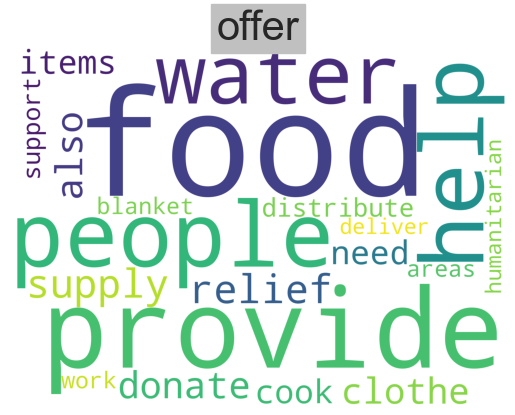

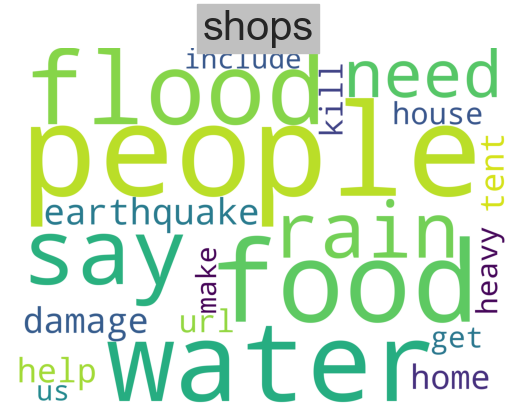

In [20]:
categories = ['offer', 'shops']

def cat_plot(categories, df):

    cv = CountVectorizer(tokenizer=tokenize,
                         token_pattern=None,
                         min_df=3,
                         max_df=0.9,
                         max_features=8000,
                         ngram_range=(1,3),
                         )

    for cat in categories:

         df_cat = df[df[cat] == 1]

         tokens = cv.fit_transform(df_cat['message_new'])
        
         # get word headings
         feature_names = cv.get_feature_names_out()
        
         freq = pd.DataFrame(tokens.toarray().sum(axis=0))
         freq.columns = ['count']
         freq.index = feature_names
         freq = freq.sort_values(by='count', ascending=False)
        
         freq_dict = freq['count'].to_dict()
         word_cloud(freq_dict, cat)

cat_plot(categories, df)

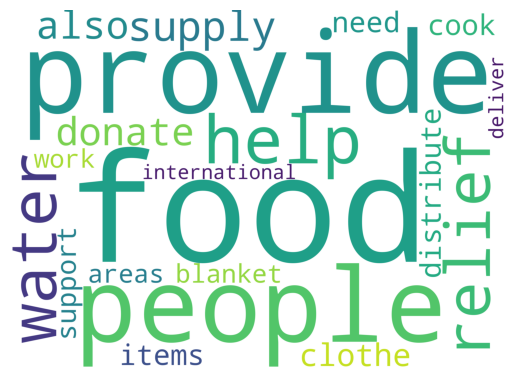

In [21]:

counter=Counter()
[counter.update(tokenize(m)) for m in test.message_new]
counter.most_common(20)
word_cloud(counter)

In [22]:
# quick lemmitizer test
from nltk.corpus import wordnet
words = ['provide', 'provided', 'providing', 'house', 'houses', 'housing']
lemmatizer = WordNetLemmatizer()
print([lemmatizer.lemmatize(word) for word in words] )
print([lemmatizer.lemmatize(word, wordnet.VERB) for word in words])

['provide', 'provided', 'providing', 'house', 'house', 'housing']
['provide', 'provide', 'provide', 'house', 'house', 'house']


In [23]:
# # Build a custom transformer which will extract the starting verb of a sentence
# class StartingVerbExtractor2(BaseEstimator, TransformerMixin):
#     """
#     Starting Verb Extractor class
# 
#     This class create a new boolean feature indicating of a sentence start with a verb or not
#     
#     Args:
#         X -> dataframe: can have multiple columns
#         col -> string: column in the data dataframe that contains the text to be searched
#         
#     Returns:
#         df -> return a new dataset with a new BOOLEAN column called 'starting_verb'
#     """
# 
#     def starting_verb(self, text):
#         sentence_list = nltk.sent_tokenize(text)
# 
#         for sentence in sentence_list:
#             pos_tags = nltk.pos_tag(tokenize(sentence))
#             if len(pos_tags) > 0:
#                 first_word, first_tag = pos_tags[0]
#                 if first_tag in ['VB', 'VBP', 'VBN', 'VBG'] or first_word == 'RT':
#                     return True
#         return False
# 
#     def fit(self, X, y=None):
#         # Given it is a transformer we can return the self 
#         return self
# 
#     def transform(self, X, col='message_new'):
#         X_tagged = X[col].apply(self.starting_verb)        
#         df = pd.DataFrame(X_tagged)
#         df.columns = ['starting_verb']
#         return df

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

As the dataset is imbalanced we need to split the data in the same proportions as the actual labels
We will use iterative stratification:
  - as the labelsets are large, 
  - works well with binary relevance
  - handles rare labels in a better way and most important, 
  - maintains the imbalance ratio of each label in each subset
    
**Note**: it is not possible to use multioutput and xgboost with callbacks or early stop for multi label, it is not supported if in a pipeline.

In [24]:
X_train, y_train, X_val, y_val, X_test, y_test = custom_test_train_split(X, y, random_state=random_state)

Total records: X(26179, 2):y(26179, 35)
Train shape: X(17452, 2):y(17452, 35)
Validation shape: X(4363, 2):y(4363, 35)
Test shape: X(4364, 2):y(4364, 35)


In [25]:
# make sure data type 'category' is kept
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17452 entries, 2 to 30262
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   message_new  17452 non-null  object  
 1   genre        17452 non-null  category
dtypes: category(1), object(1)
memory usage: 289.9+ KB


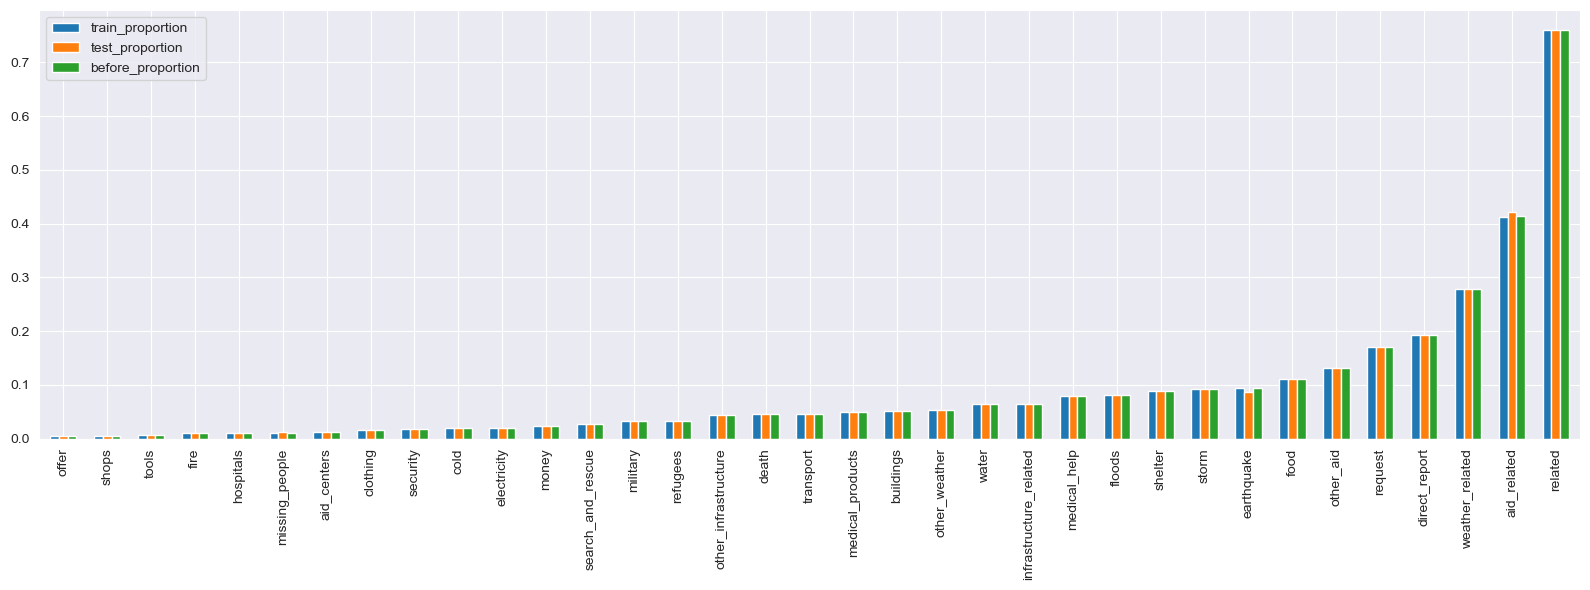

In [26]:
# make sure proportions are the same for original y, test and train datasets due to stratified split
plot_label_proportions(y, y_train, y_test)

> Label were split in the same proportions between train, validation and test datasets

In [27]:
# Oversample the minority classes
ml_sampler = MLOverSampling()
print('Training shapes before: {} {}'.format(X_train.shape, y_train.shape)) 
X_train_sub, y_train_sub, imbalanced_labels = ml_sampler.minority_oversampling(X_train, y_train)
print('Duplicated samples: {} {}'.format(X_train_sub.shape, y_train_sub.shape))    

Training shapes before: (17452, 2) (17452, 35)
Imbalanced labels: ['offer', 'security', 'clothing', 'missing_people', 'tools', 'hospitals', 'shops', 'aid_centers', 'fire']
Minority samples: (1395, 2) (1395, 35)
Duplicated samples: (30815, 2) (30815, 35)


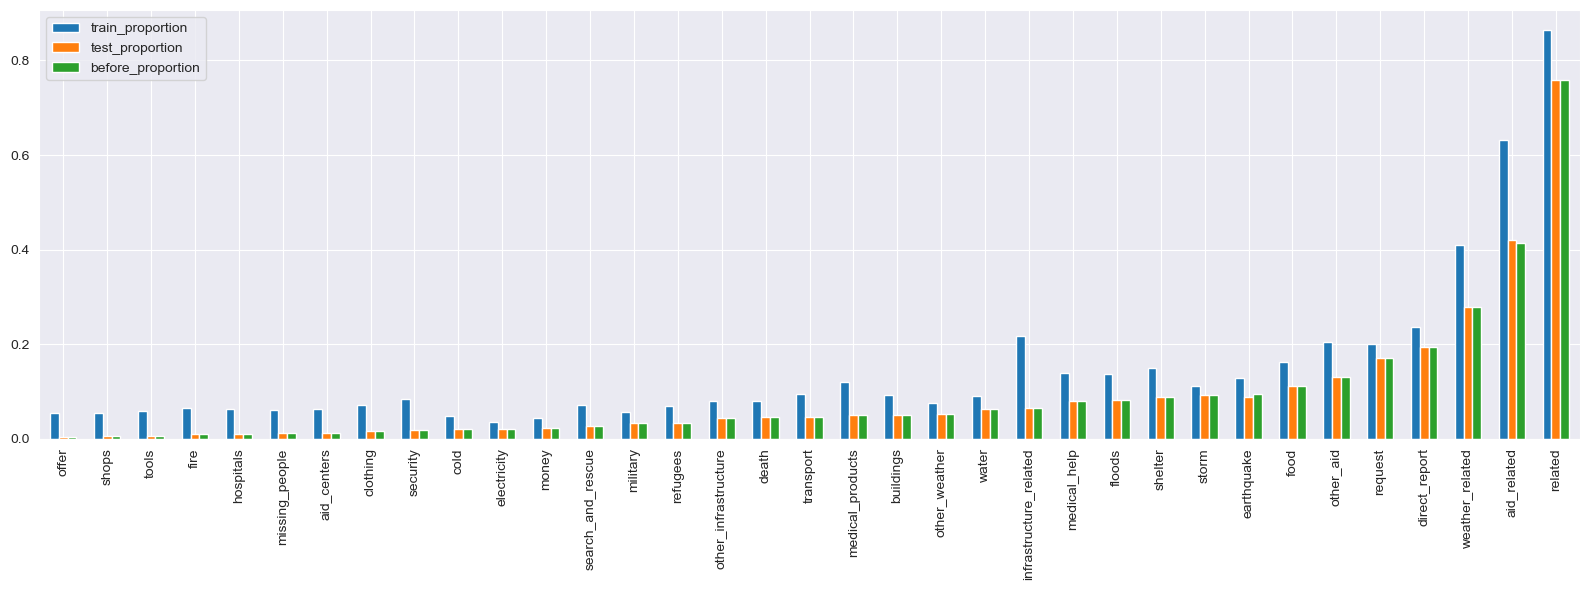

In [29]:
plot_label_proportions(y, y_train_sub, y_test)

In [ ]:
# to handle imbalance, calculate a global scale_pos_weight, which are total negative / total positive responses
pos = y_train[y_train == 1].count().sum()
neg = y_train[y_train == 0].count().sum()
pos_weight = np.sqrt(neg / pos)
pos_weight

In [177]:
xgb.set_config(verbosity=1)

# cache transformers so they are only executed once, especially during gridsearch
cachedir = '../cache'
# memory = Memory(location=cachedir, verbose=10)

# using defaults of XGBOOST
params = {
    'objective': 'binary:logistic',    
    # 'objective': 'binary:logitraw',
    'n_jobs': -1,
    'max_depth': 12,
    'min_child_weight': 1.4,
    'gamma': 0.64,
    # 'eval_metric': 'map', # error, error@0.5 mlogloss, mae, auc, map, aucpr, logloss
    'eval_metric': 'aucpr',
    'booster': 'gbtree',   
    'n_estimators': 100,
    'colsample_bytree': 1,
    'subsample': 0.9, # default is 1
    'tree_method': 'exact', # exact, approx, auto
    'scale_pos_weight': 1,
    'max_delta_step': 15.5,
    'reg_lambda': 0.004, # lambda
    'reg_alpha': 0.003, # alpha
    'learning_rate': 0.4,
    'verbosity': 1,
    # 'num_round': 10,
    'random_state' : random_state,
    # one_hot_encoding support is not compatible with column transformer which return an array
    # 'enable_categorical': True,
    # 'max_cat_to_onehot': 5,
    'multi_strategy':"one_output_per_tree",  
}

text_nlp = Pipeline(steps=[
    ('vect', CountVectorizer(tokenizer=tokenize, 
                             token_pattern=None,
                             min_df=3,   # if word appears in less than 3 documents ignore it
                             max_df=0.90, # remove too frequent words in 95% of documents
                             max_features=10000,
                             ngram_range=(1,2))),    
    ('tfidf', TfidfTransformer(sublinear_tf=False)),    
    ],
    verbose=True)

# preprocessor for NLP
preprocessor = ColumnTransformer(transformers=[
    ('text_vect', text_nlp, 'message_new'),
    ('one_hot', OneHotEncoder(), ['genre']),    
],
    verbose_feature_names_out=False,
    remainder='drop',
    verbose=True,
)

pipeline_base = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', xgb.XGBClassifier(**params)),    
],
    memory=cachedir,
    verbose=True,
)

In [178]:
# train classifier
# label_ratio = ml_sampler.get_sample_ratio(y_train)
# sample_weights = calculate_sample_weights(label_ratio, y_train, power=1)
# pipeline_base.fit(X_train, y_train, clf__sample_weight=sample_weights)
# pipeline_base.fit(X_train_sub, y_train_sub, clf__sample_weight=sample_weights)
pipeline_base.fit(X_train_sub, y_train_sub)
rmtree(cachedir)

[Pipeline] .............. (step 1 of 2) Processing vect, total= 2.2min
[Pipeline] ............. (step 2 of 2) Processing tfidf, total=   0.0s
[ColumnTransformer] ..... (1 of 2) Processing text_vect, total= 2.2min
[ColumnTransformer] ....... (2 of 2) Processing one_hot, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 2.2min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 3.2min


In [179]:
# Evaluate results
y_pred_val, score_base = evaluate(X_val, y_val, pipeline_base, zero_division=0)
auc_base = print_results(y_val, y_pred_val, pipeline_base)

                        precision    recall  f1-score   support

               related       0.84      0.92      0.88      3313
               request       0.72      0.60      0.65       744
                 offer       0.00      0.00      0.00        20
           aid_related       0.69      0.68      0.68      1801
          medical_help       0.53      0.33      0.41       347
      medical_products       0.53      0.32      0.40       219
     search_and_rescue       0.32      0.15      0.20       121
              security       0.32      0.08      0.12        79
              military       0.59      0.31      0.40       144
                 water       0.73      0.64      0.68       278
                  food       0.78      0.71      0.75       486
               shelter       0.71      0.58      0.64       385
              clothing       0.63      0.54      0.58        68
                 money       0.48      0.31      0.38       100
        missing_people       0.36      

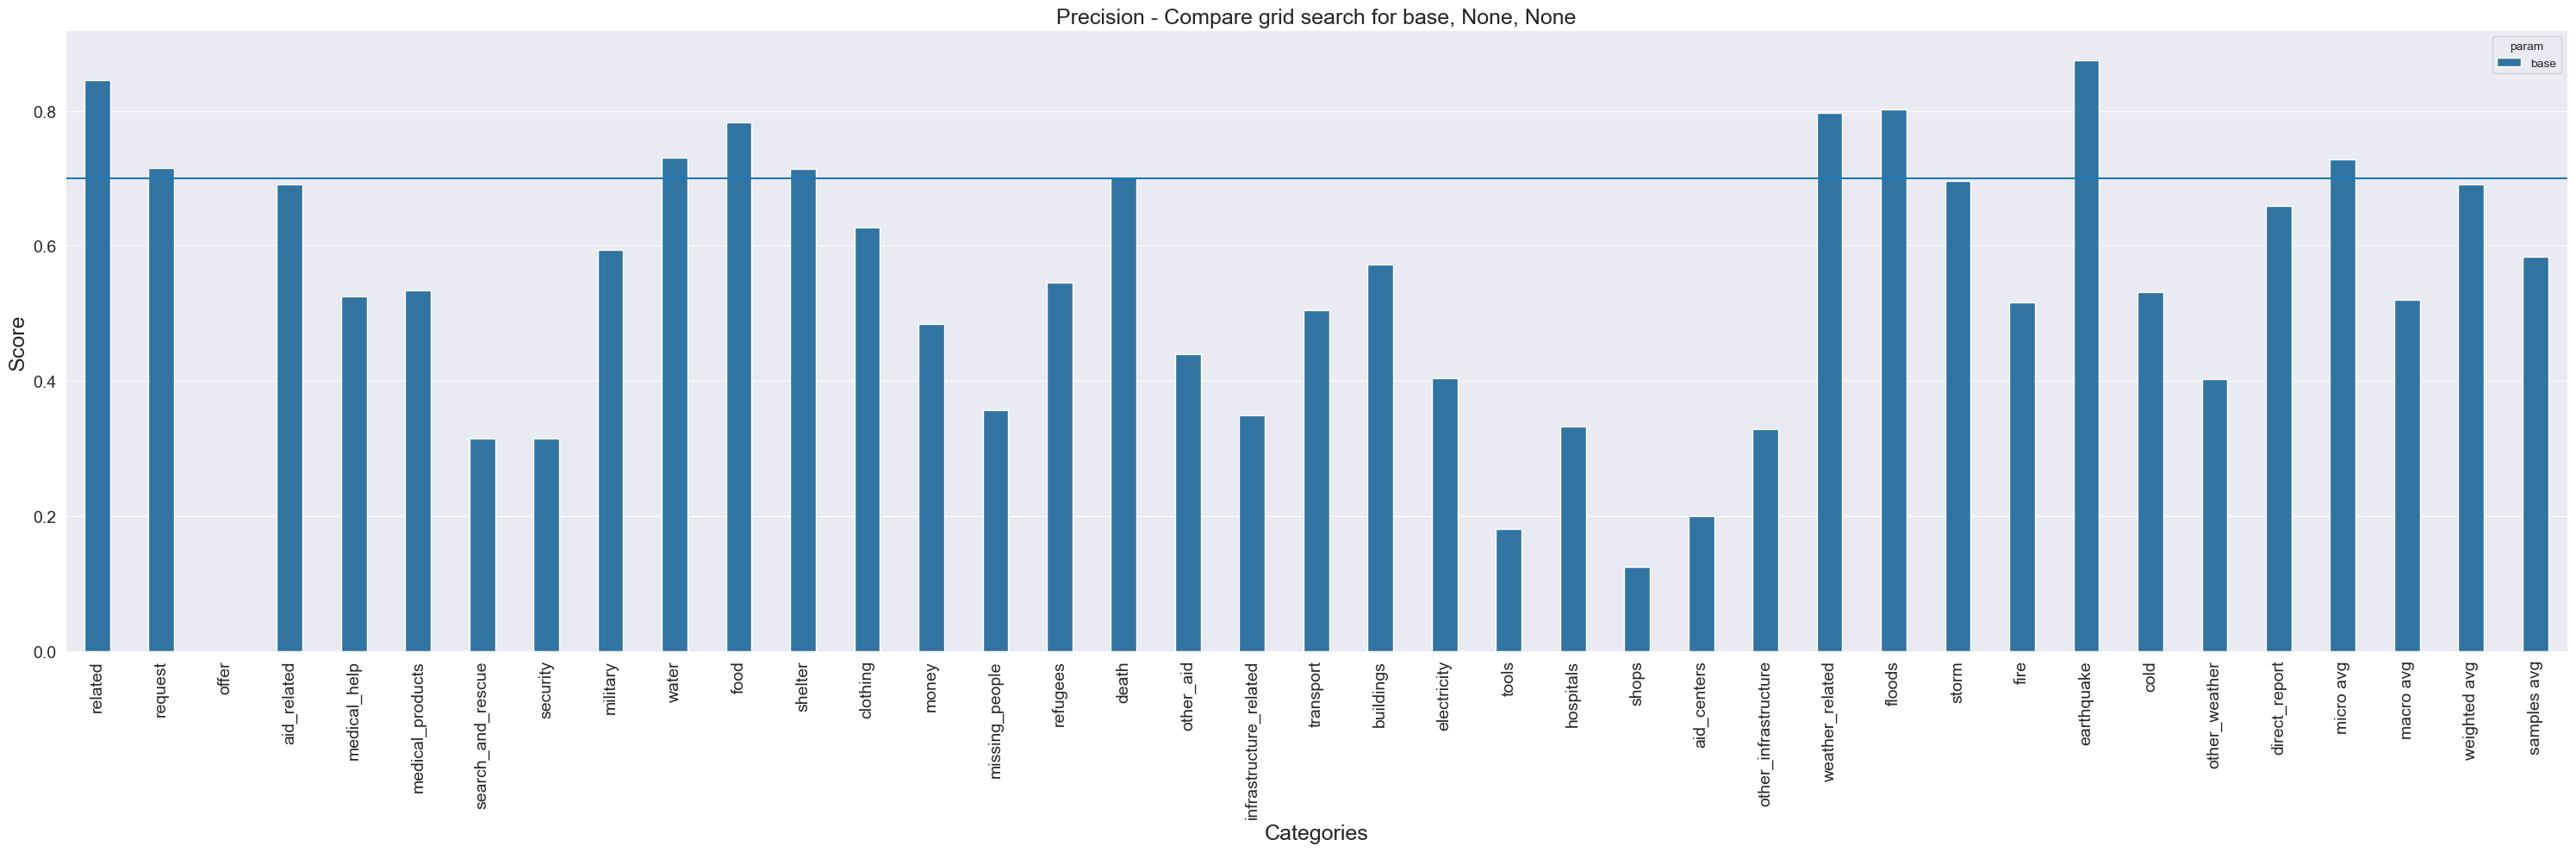

In [180]:
plot_scores(score1=score_base, score2=None, score3=None, score1_name='base', score2_name=None, score3_name=None)

*-### 6. Improve your model with GridSearch
Use grid search to find better parameters. 

Scoring to consider for imbalance is: f1_micro, f1_weighted, roc_auc, auc
Set parameter max_delta_step to a finite number (say 1) to help convergence

[Click here to see XGBOOST documenation how to handle Imbalance](https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html#handle-imbalanced-dataset)

In [181]:
# scoring = 'f1_micro'
# scoring = 'precision'
verbose = 1

# scoring = make_scorer(precision_score, average = 'samples', zero_division=0) 
# scoring = make_scorer(precision_score, average = 'weighted', zero_division=0)

# when we want to treat all classes in the same way
scoring = make_scorer(precision_score, average = 'macro', zero_division=0)

# when we want to give preference to higher classes
# scoring = make_scorer(precision_score, average = 'micro', zero_division=0)
# try also samples
# sample_weights = calculate_sample_weights(label_ratio, y_train_sub, power=1)

In [ ]:
## Try Bayes_Optimzation
def objective(trial):

    # param = {
    #     "verbosity": 0,
    #     "objective": "binary:logistic",
    #     # use exact for small dataset.
    #     "tree_method": "exact",
    #     # defines booster, gblinear for linear functions.
    #     "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
    #     # L2 regularization weight.
    #     "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
    #     # L1 regularization weight.
    #     "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
    #     # sampling ratio for training data.
    #     "subsample": trial.suggest_float("subsample", 0.2, 1.0),
    #     # sampling according to each tree.
    #     "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    # }
    # 
    # if param["booster"] in ["gbtree", "dart"]:
    #     # maximum depth of the tree, signifies complexity of the tree.
    #     param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
    #     # minimum child weight, larger the term more conservative the tree.
    #     param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
    #     param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
    #     # defines how selective algorithm is.
    #     param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    #     param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    # 
    # if param["booster"] == "dart":
    #     param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
    #     param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
    #     param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
    #     param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
        
    param = {        
        # 'clf__n_estimators': trial.suggest_int('clf__n_estimators', low=50, high=200, step=50),
        # 'clf__scale_pos_weight': trial.suggest_float('clf__scale_pos_weight', low=1, high=20),    
        'clf__max_delta_step': trial.suggest_float('clf__max_delta_step', low=0.0001, high=100, log=True),             
        'clf__max_depth': trial.suggest_int('clf__max_depth', low=2, high=15, step=1),
        'clf__reg_lambda': trial.suggest_float('clf__reg_lambda', low=0.0001, high=100, log=True), 
        'clf__gamma': trial.suggest_float('clf__gamma', low=0.0001, high=100, log=True),
        'clf__min_child_weight': trial.suggest_float('clf__min_child_weight', low=1, high=100, log=True),     
        'clf__reg_alpha': trial.suggest_float('clf__reg_alpha', low=0.0001, high=100, log=True),  
        'clf__learning_rate': trial.suggest_float('clf__learning_rate', low=0.0001, high=100, log=True),
    }

    # y_pred = pipeline_base.predict(X_val)
    # precision = precision_score(y_val, y_pred, average='macro')
    # auc = roc_auc_score(y_val, y_pred)
    
    scoring = make_scorer(precision_score, average = 'macro', zero_division=0)      
    pipeline_base.set_params(**param)
    
    score = cross_val_score(estimator=pipeline_base,
                             X=X_train_sub, 
                             y=y_train_sub, 
                             scoring=scoring,
                             cv=MultilabelStratifiedKFold(n_splits=2,
                                                           shuffle=True,
                                                           random_state=random_state),
                             # n_jobs=-1
                            ).mean()
    
    return score

optuna.logging.disable_default_handler()
study = optuna.create_study(sampler=TPESampler(), direction="maximize")
start = time()
study.optimize(objective, n_trials=50)
total_time = time() - start

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
rmtree(cachedir)

[Pipeline] .............. (step 1 of 2) Processing vect, total=  53.7s
[Pipeline] ............. (step 2 of 2) Processing tfidf, total=   0.0s
[ColumnTransformer] ..... (1 of 2) Processing text_vect, total=  53.7s
[ColumnTransformer] ....... (2 of 2) Processing one_hot, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=  53.7s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  46.6s
[Pipeline] .............. (step 1 of 2) Processing vect, total=  55.3s
[Pipeline] ............. (step 2 of 2) Processing tfidf, total=   0.0s
[ColumnTransformer] ..... (1 of 2) Processing text_vect, total=  55.3s
[ColumnTransformer] ....... (2 of 2) Processing one_hot, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=  55.3s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  47.2s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  32.6s


In [ ]:
print(f"---Bayesian Optimization---")
print(f"Total time: {total_time:.2f} seconds")
print(f"Number of iterations: {len(study.trials)}")
print(f"Best trial index: {study.best_trial.number}")
print(f"Best score: {study.best_trial.value}")
print(f"Best hyperparameters: {study.best_params}")

In [184]:
test = study.trials_dataframe()
# test.to_csv('../data/study_results.csv')
test

,number,value,datetime_start,datetime_complete,duration,params_clf__gamma,params_clf__learning_rate,params_clf__max_depth,params_clf__reg_alpha,params_clf__reg_lambda,state
0,0,0.9742877934339215784120824537239968776702880859375000000000,2024-09-02 21:52:59.797814,2024-09-02 21:59:11.949003,0 days 00:06:12.151189,3.874494709034061123986703023547306656837463378906250000000000000,0.005310021592446079012617143888519422034732997417449951171875000000,7,0.00123198435788564059772953740434786595869809389114379882812500000,0.00461284290836888512948865681551069428678601980209350585937500000,COMPLETE
1,1,0.9392163093763260528490377510024700313806533813476562500000,2024-09-02 21:59:11.949532,2024-09-02 22:04:10.940792,0 days 00:04:58.991260,0.013492828341477266715364713434155419236049056053161621093750000,0.046134331267828045108903012305745505727827548980712890625000000000,10,0.00155620386597172481041306824067760317120701074600219726562500000,0.01035764059287226819539018407567709800787270069122314453125000000,COMPLETE
2,2,0.0000000000000000000000000000000000000000000000000000000000,2024-09-02 22:04:10.941250,2024-09-02 22:07:59.293087,0 days 00:03:48.351837,0.022821626539266819805318320391052111517637968063354492187500000,0.000493610659530375637735200022859771706862375140190124511718750000,6,0.35359945490629479669664192442724015563726425170898437500000000000,0.00026140594200204281174343412530447494646068662405014038085937500,COMPLETE
3,3,0.0000000000000000000000000000000000000000000000000000000000,2024-09-02 22:07:59.293574,2024-09-02 22:12:45.900331,0 days 00:04:46.606757,0.267966502591309940761732377723092213273048400878906250000000000,0.000323934343440002788135079203613031495478935539722442626953125000,9,0.57206193281451223064948408136842772364616394042968750000000000000,0.00339675610033989385308506037119968823390081524848937988281250000,COMPLETE
4,4,0.8065501969007045079962381350924260914325714111328125000000,2024-09-02 22:12:45.900798,2024-09-02 22:16:19.312340,0 days 00:03:33.411542,0.000111963017009141245668157882420246096444316208362579345703125,1.188277721814444909398389427224174141883850097656250000000000000000,7,0.00424513138767702771086964830260512826498597860336303710937500000,0.01467020356172302891772929456237761769443750381469726562500000000,COMPLETE
5,5,0.9260787114297943656282541269320063292980194091796875000000,2024-09-02 22:16:19.312811,2024-09-02 22:21:15.076632,0 days 00:04:55.763821,0.002279985505914613151678960178969646221958100795745849609375000,0.028641480403465317122746469635785615537315607070922851562500000000,10,2.36566830673754058267377331503666937351226806640625000000000000000,0.58542146983822795913710024251486174762248992919921875000000000000,COMPLETE
6,6,0.7593883304472411888141891722625587135553359985351562500000,2024-09-02 22:21:15.077096,2024-09-02 22:25:55.719030,0 days 00:04:40.641934,0.104903518830263109418154954255442135035991668701171875000000000,1.408384645218787589726616715779528021812438964843750000000000000000,15,0.00053356408941299723197593252166370803024619817733764648437500000,0.00041690889565506521023674491033261801931075751781463623046875000,COMPLETE
7,7,0.0000000000000000000000000000000000000000000000000000000000,2024-09-02 22:25:55.719496,2024-09-02 22:31:34.905100,0 days 00:05:39.185604,0.139768400519556801331333417692803777754306793212890625000000000,0.000118825800977394343388958419804879440562217496335506439208984375,12,0.91683331937608636419412277973606251180171966552734375000000000000,1.16046882226892966727405109850224107503890991210937500000000000000,COMPLETE
8,8,0.0000000000000000000000000000000000000000000000000000000000,2024-09-02 22:31:34.905587,2024-09-02 22:37:30.344286,0 days 00:05:55.438699,0.000425205145342798891336388855677341780392453074455261230468750,0.000610195365233810326117958044989109112066216766834259033203125000,13,0.06083195895709642836424180245558090973645448684692382812500000000,1.50279417816281690711832652596058323979377746582031250000000000000,COMPLETE
9,9,0.

In [1]:
fig = plt.figure(figsize=(20,6))
sns.lineplot(data=test, x='params_clf__gamma', y='value', label='max step')
sns.lineplot(data=test, x='params_clf__max_depth', y='value', label='max depth')
plt.show()

NameError: name 'plt' is not defined

# Total time: 606621.41 seconds
# Number of iterations: 200
# Best trial index: 199
# Best score: 0.9442869274831933
# Best hyperparameters: {'clf__n_estimators': 100, 'clf__scale_pos_weight': 1.0099199883180554, 'clf__max_delta_step': 15.540279512814008, 'clf__max_depth': 12, 'clf__reg_lambda': 0.0038376550609826978, 'clf__gamma': 0.6399466245757152, 'clf__min_child_weight': 1.3322310688472614, 'clf__reg_alpha': 0.003113428583080456, 'clf__learning_rate': 0.038001681926279306}

In [187]:
pipeline_base.set_params(**study.best_params)
# pipeline_base['clf'].get_params()
pipeline_base.fit(X_train_sub, y_train_sub)
y_pred_val, score2 = evaluate(X_val, y_val, pipeline_base)
auc_2 = print_results(y_val, y_pred_val, pipeline_base)

[Pipeline] .............. (step 1 of 2) Processing vect, total= 2.2min
[Pipeline] ............. (step 2 of 2) Processing tfidf, total=   0.0s
[ColumnTransformer] ..... (1 of 2) Processing text_vect, total= 2.2min
[ColumnTransformer] ....... (2 of 2) Processing one_hot, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 2.2min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 4.8min
                        precision    recall  f1-score   support

               related       0.96      0.31      0.47      3313
               request       0.88      0.14      0.25       744
                 offer       0.00      0.00      0.00        20
           aid_related       0.85      0.15      0.25      1801
          medical_help       0.59      0.03      0.05       347
      medical_products       0.72      0.08      0.15       219
     search_and_rescue       0.56      0.04      0.08       121
              security       0.00      0.00      0.00        

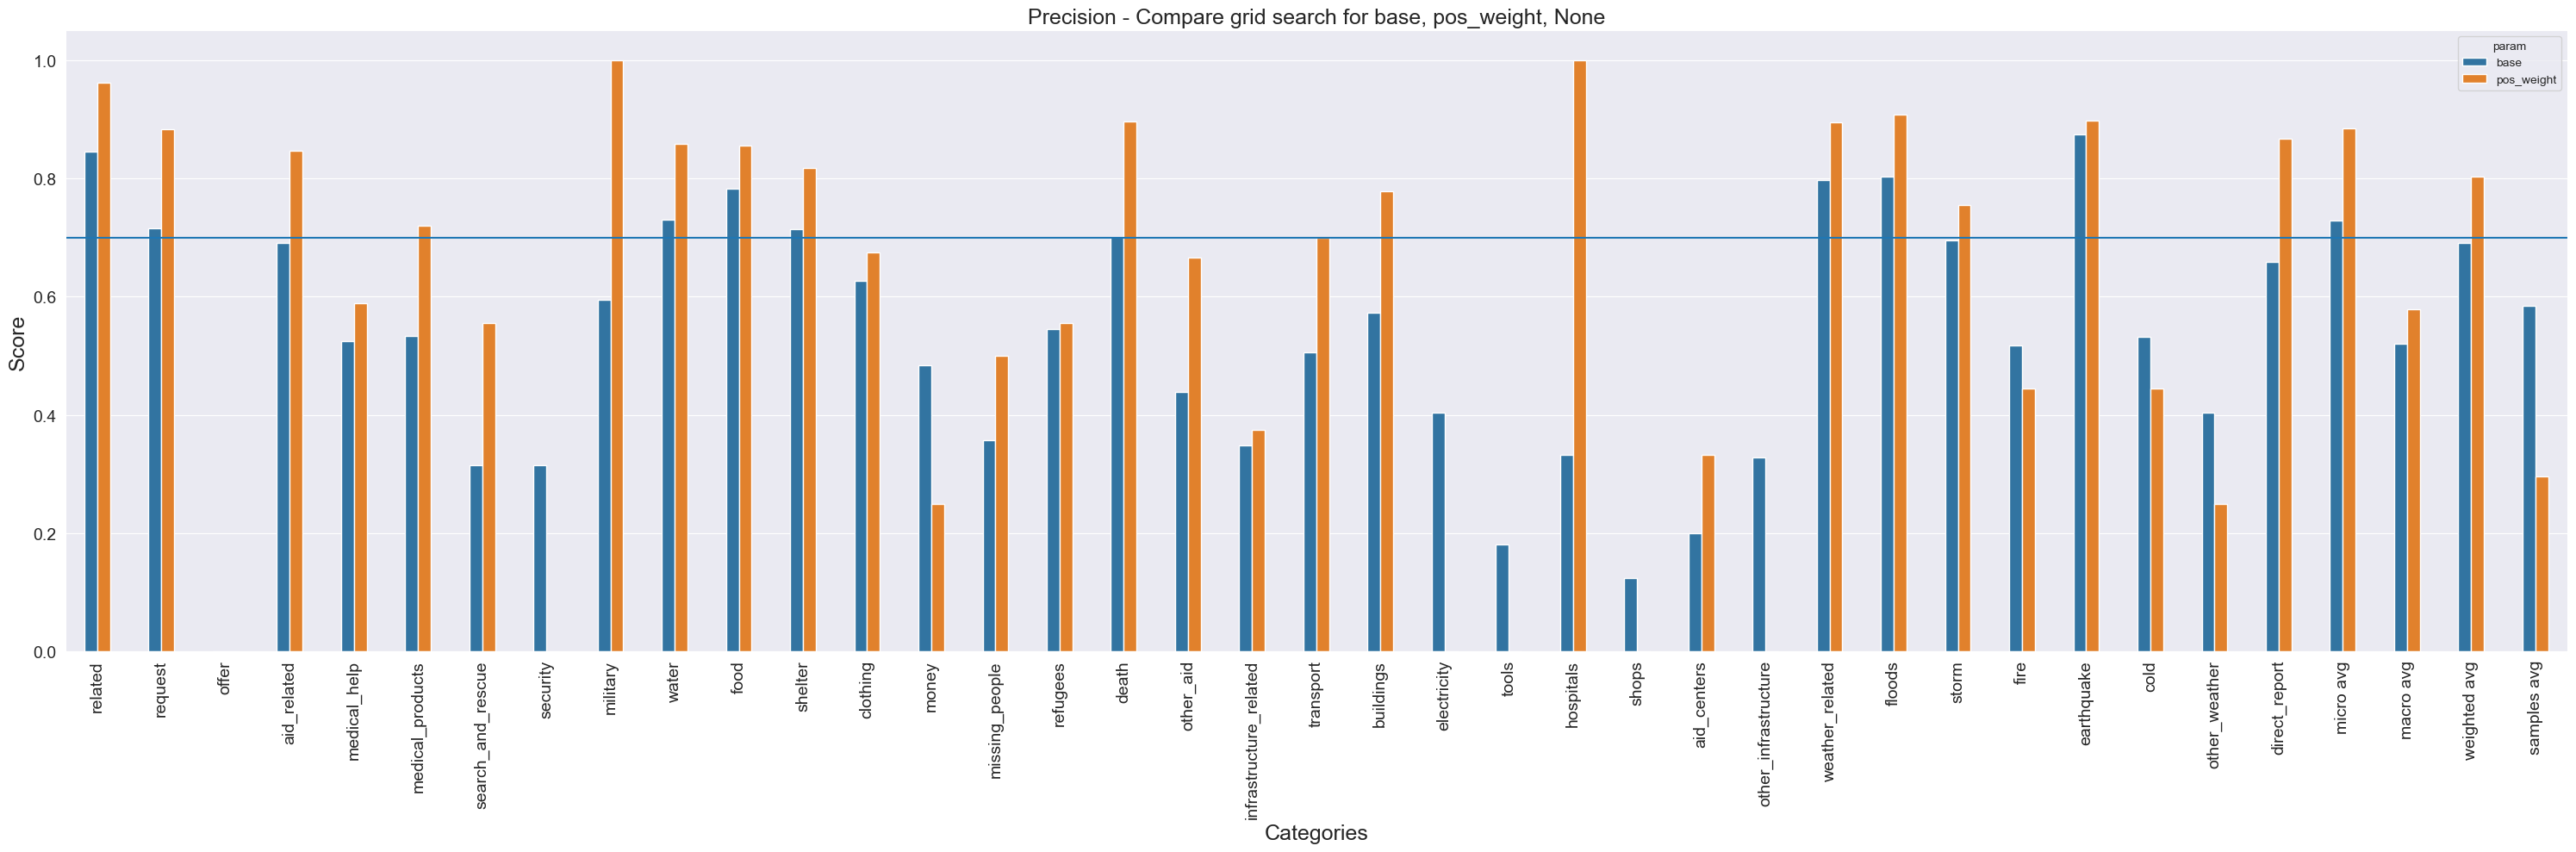

In [188]:
# Update model parameters with cross validation results
plot_scores(score1=score_base, score2=score2, score3=None, score1_name='base', score2_name='pos_weight', score3_name=None)

In [ ]:
# auc score, came to 71.2 but poor 
#       micro avg       0.46      0.81      0.58     13815
#              macro avg       0.37      0.55      0.44     13815
#           weighted avg       0.51      0.81      0.61     13815
#            samples avg       0.42      0.67      0.47     13815

# Best hyperparameters: {'clf__n_estimators': 150, 'clf__scale_pos_weight': 15.312350363689909, 'clf__max_delta_step': 19.308026920713157, 'clf__max_depth': 7, 'clf__reg_lambda': 0.8393669062781971, 'clf__gamma': 0.2757782725590271, 'clf__min_child_weight': 9.793355968118075, 'clf__reg_alpha': 0.05350879464634534, 'clf__learning_rate': 0.2632068449568947}

In [ ]:
from imxgboost.imbalance_xgb import imbalance_xgboost as imb_xgb

In [ ]:
xgboster_focal = imb_xgb(special_objective='focal')
# xgboster_weight = imb_xgb(special_objective='weighted')
CV_focal_booster = GridSearchCV(xgboster_focal, {"focal_gamma":[1.0,1.5,2.0,2.5,3.0]})
# CV_weight_booster = GridSearchCV(xgboster_weight, {"imbalance_alpha":[1.5,2.0,2.5,3.0,4.0]})
CV_focal_booster.fit(X_train.to_numpy(), y_train.to_numpy())
opt_focal_booster = CV_focal_booster.best_estimator_
opt_focal_booster

In [ ]:
preds = opt_focal_booster.predict_determine(X_test.to_numpy(), y=None) 

In [ ]:
# def plot_scores(score1, score2, score3, score1_name, score2_name, score3_name):
# 
#     if score1:
#         plot1 = pd.DataFrame.from_dict(score1, orient='index', dtype='float16')
#         plot1['param'] = score1_name
# 
#     if score2:
#         plot2 = pd.DataFrame.from_dict(score2, orient='index', dtype='float16')
#         plot2['param'] = score2_name
#     else: 
#         plot2 = pd.DataFrame()
# 
#     if score3:
#         plot3 = pd.DataFrame.from_dict(score3, orient='index', dtype='float16')
#         plot3['param'] = score3_name
#     else: 
#         plot3 = pd.DataFrame()        
# 
#     df_all = pd.concat([plot1, plot2, plot3])
#     plt.figure(figsize=(30, 10))
#     sns.barplot(data=df_all, x=df_all.index, y='precision', hue='param', width=0.4, dodge=True)
#     plt.axhline(0.7)
#     plt.xticks(rotation=90, fontsize=14)
#     plt.yticks(fontsize=14)
#     plt.xlabel('Categories', fontsize=18)
#     plt.ylabel('Score', fontsize=18)
#     plt.title('Precision - Compare grid search for {}, {}, {}'.format(score1_name, score2_name, score3_name), fontsize=18)
#     plt.tight_layout()


In [ ]:
# def cv_predefined(X_train, y_train, X_val, y_val, pipeline, hyperparameters, scoring='roc_auc', verbose=3, error_score=np.nan):
# 
#     # Build a predefined split with validation set to be used for evaluation
# 
#     # Merge training and validation set back together
#     X_train_val = pd.concat([X_train, X_val])
#     y_train_val = pd.concat([y_train, y_val])
# 
#     # Create a list where train data indices are -1 and validation data indices are 0
#     split_index = [0 if x in X_val.index else -1 for x in X_train_val.index]
#     pds = PredefinedSplit(test_fold=split_index)
#     print('Number of training splits: {}'.format(pds.get_n_splits()))
# 
#     # create grid search object
#     gridsearch = GridSearchCV(pipeline,
#                       param_grid=hyperparameters,
#                       refit=False,
#                       return_train_score=True,
#                       # n_jobs=4,
#                       scoring=scoring,
#                       # cv=MultilabelStratifiedKFold(n_splits=2, shuffle=True, random_state=0),
#                       cv=pds,       
#                       verbose=verbose,
#                       error_score=error_score
#                       )
# 
#     # compare results of both training and validation datasets
#     gridsearch.fit(X_train_val, y_train_val)
# 
#     print('\nBest score: {}'.format(gridsearch.best_score_))
#     print("\nBest Parameters:", gridsearch.best_params_)
# 
#     rmtree(cachedir)
# 
#     return gridsearch

## Step 0 - NGram range

To help the model to consider context better, would it better to work with individual words or collection of words ?

In [ ]:
# clear the garbage to free memory
gc.collect()

In [164]:
hyperparameters = {
    'clf__eval_metric' : ['logloss', 'aucpr', 'error', 'map', 'mae'], 
}

gridsearch1 = cv_predefined(X_train=X_train_sub,
                            y_train=y_train_sub,
                            X_val=X_val,
                            y_val=y_val,
                            pipeline=pipeline_base,
                            hyperparameters=hyperparameters,
                            scoring=scoring,
                            verbose=verbose,
                            random_state=random_state)

rmtree(cachedir)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[Pipeline] .............. (step 1 of 2) Processing vect, total= 1.4min
[Pipeline] ............. (step 2 of 2) Processing tfidf, total=   0.0s
[ColumnTransformer] ..... (1 of 2) Processing text_vect, total= 1.4min
[ColumnTransformer] ....... (2 of 2) Processing one_hot, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 1.4min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 3.2min
[CV] END ...........................clf__eval_metric=logloss; total time= 5.3min
[Pipeline] .............. (step 1 of 2) Processing vect, total= 1.3min
[Pipeline] ............. (step 2 of 2) Processing tfidf, total=   0.0s
[ColumnTransformer] ..... (1 of 2) Processing text_vect, total= 1.3min
[ColumnTransformer] ....... (2 of 2) Processing one_hot, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 1.3min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 3.2min
[CV] EN

In [167]:
gridsearch1.cv_results_

{'mean_fit_time': array([271.66241463, 188.94021972, 186.42890652, 191.51199969,
        189.69269244]),
 'std_fit_time': array([3.89538739, 3.94123004, 2.16753756, 4.24589477, 1.75305858]),
 'mean_score_time': array([40.31262573, 40.09950972, 37.93607903, 38.5475231 , 38.14767957]),
 'std_score_time': array([2.29276156, 1.42258378, 1.18802246, 0.54607122, 0.08421288]),
 'param_clf__eval_metric': masked_array(data=['logloss', 'aucpr', 'error', 'map', 'mae'],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'clf__eval_metric': 'logloss'},
  {'clf__eval_metric': 'aucpr'},
  {'clf__eval_metric': 'error'},
  {'clf__eval_metric': 'map'},
  {'clf__eval_metric': 'mae'}],
 'split0_test_score': array([0.9477491, 0.9477491, 0.9477491, 0.9477491, 0.9477491]),
 'split1_test_score': array([0.94946117, 0.94946117, 0.94946117, 0.94946117, 0.94946117]),
 'split2_test_score': array([0.94925522, 0.94925522, 0.94925522, 0.94925522, 0

In [165]:
# Update model parameters with cross validation results
pipeline_base.set_params(**gridsearch1.best_params_)
pipeline_base.fit(X_train_sub, y_train_sub)
y_pred_val, score1 = evaluate(X_val, y_val, pipeline_base)
auc_1 = print_results(y_val, y_pred_val, pipeline_base)

[Pipeline] .............. (step 1 of 2) Processing vect, total= 1.8min
[Pipeline] ............. (step 2 of 2) Processing tfidf, total=   0.0s
[ColumnTransformer] ..... (1 of 2) Processing text_vect, total= 1.8min
[ColumnTransformer] ....... (2 of 2) Processing one_hot, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 1.8min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 4.7min
                        precision    recall  f1-score   support

               related       0.88      0.88      0.88      3313
               request       0.76      0.55      0.64       744
                 offer       0.00      0.00      0.00        20
           aid_related       0.73      0.61      0.67      1801
          medical_help       0.55      0.24      0.34       347
      medical_products       0.58      0.27      0.37       219
     search_and_rescue       0.39      0.11      0.17       121
              security       0.50      0.09      0.15        

In [ ]:
# plot_scores(score1=score_base, score2=score1, score3=None, score1_name='base', score2_name='max_featurs', score3_name=None)

In [ ]:
# cv_plot_scores(gridsearch1)

In [ ]:
# print('Base AUC = {}, Max features AUC = {}'.format(auc_base, auc_1))

## Step 2 - Tune pos_weight

Controlling Imbalance

Balancing of positive and negative weights to handle imbalance

In [ ]:
hyperparameters = {
    'clf__scale_pos_weight' : [1, 1.3, 1.5, 2, 2.5],
    # 'clf__max_delta_step' : [None, 1, 3],    
}

gridsearch2 = cv_predefined(X_train=X_train_sub,
                            y_train=y_train_sub,
                            X_val=X_val,
                            y_val=y_val,
                            pipeline=pipeline_base,
                            hyperparameters=hyperparameters,
                            scoring=scoring,
                            verbose=verbose,
                            random_state=random_state)

rmtree(cachedir)

In [ ]:
# param_pos_weight = {'clf__scale_pos_weight': 2}
# full_pipeline.set_params(**param_pos_weight)
# full_pipeline['clf'].get_params()

In [ ]:
# Update model parameters with cross validation results
pipeline_base.set_params(**gridsearch2.best_params_)
pipeline_base.fit(X_train_sub, y_train_sub)
y_pred_val, score2 = evaluate(X_val, y_val, pipeline_base)
auc_2 = print_results(y_val, y_pred_val, pipeline_base)

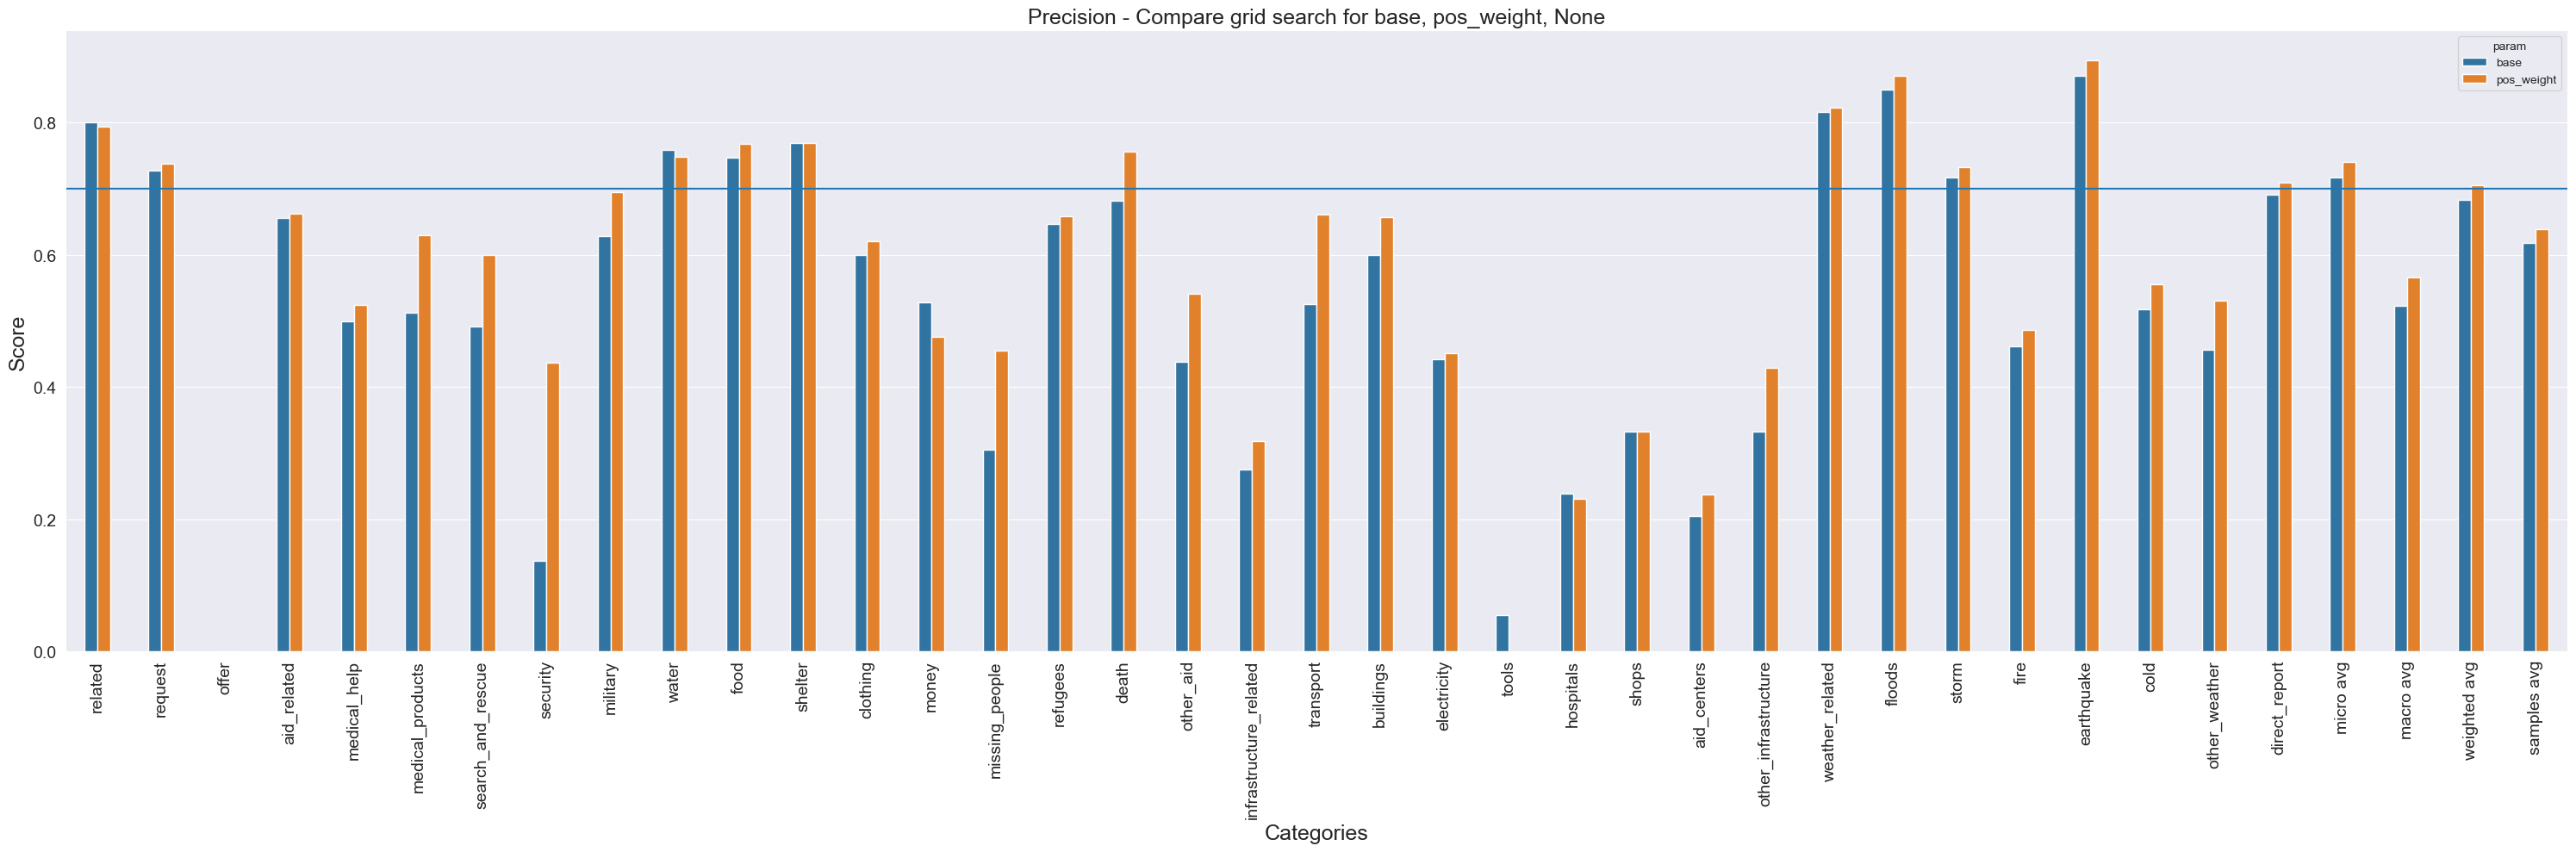

In [138]:
plot_scores(score1=score_base, score2=score2, score3=None, score1_name='base', score2_name='pos_weight', score3_name=None)

In [128]:
cv_plot_scores(gridsearch2)

NameError: name 'gridsearch2' is not defined

In [ ]:
print('Base AUC = {}, grid search AUC = {}'.format(auc_base, auc_2))

## Step 3 - Grid search for max depth and min child weight

Control over fitting and model complexity

### max depth

In [ ]:
hyperparameters = {
    'clf__max_depth' : [5, 6, 7, 8],
}

gridsearch3 = cv_predefined(X_train=X_train_sub,
                            y_train=y_train_sub,
                            X_val=X_val,
                            y_val=y_val,
                            pipeline=pipeline_base,
                            hyperparameters=hyperparameters,
                            scoring=scoring,
                            verbose=verbose,
                            random_state=random_state,
                            label_ratio=None,
                            calc_sample_ratio=False,
                            )

rmtree(cachedir)

In [ ]:
# Update model parameters with cross validation results
pipeline_base.set_params(**gridsearch3.best_params_)
# full_pipeline.fit(X_train_sub, y_train_sub, clf__sample_weight=sample_weights)
pipeline_base.fit(X_train_sub, y_train_sub)
y_pred_val, score3 = evaluate(X_val, y_val, pipeline_base)
auc_3 = print_results(y_val, y_pred_val, pipeline_base)

In [ ]:
plot_scores(score1=score_base, score2=score2, score3=score3, score1_name='base', score2_name='pos_weight', score3_name='max_depth')

In [ ]:
cv_plot_scores(gridsearch3)

### min child weight

In [ ]:
hyperparameters = {
    'clf__min_child_weight': [1, 1.5, 2, 2.5, 3]
}

gridsearch4 = cv_predefined(X_train=X_train_sub,
                            y_train=y_train_sub,
                            X_val=X_val,
                            y_val=y_val,
                            pipeline=pipeline_base,
                            hyperparameters=hyperparameters,
                            scoring=scoring,
                            verbose=verbose,
                            random_state=random_state,
                            label_ratio=None,
                            calc_sample_ratio=False,
                            )

rmtree(cachedir)

In [ ]:
# Update model parameters with cross validation rsults
pipeline_base.set_params(**gridsearch4.best_params_)
# full_pipeline.fit(X_train_sub, y_train_sub, clf__sample_weight=sample_weights)
pipeline_base.fit(X_train_sub, y_train_sub)
y_pred_val, score4 = evaluate(X_val, y_val, pipeline_base)
auc_4 = print_results(y_val, y_pred_val, pipeline_base)

In [ ]:
plot_scores(score1=score_base, score2=score3, score3=score4, score1_name='base', score2_name='gamma', score3_name='min_child_weight')

In [ ]:
print('Base AUC = {}\npos_weight search AUC = {}\nmin_child_weight AUC = {}\n'.format(auc_base, auc_2, auc_4))

In [ ]:
# Best Parameters: {'clf__max_depth': 12, 'clf__min_child_weight': 1}

In [ ]:
cv_plot_scores(gridsearch4)

## Step 4 - Tune Gamma

In [ ]:
hyperparameters = {
    'clf__gamma': [0.1, 1, 2],
}

gridsearch5 = cv_predefined(X_train=X_train_sub,
                            y_train=y_train_sub,
                            X_val=X_val,
                            y_val=y_val,
                            pipeline=pipeline_base,
                            hyperparameters=hyperparameters,
                            scoring=scoring,
                            verbose=verbose,
                            random_state=random_state,
                            label_ratio=None,
                            calc_sample_ratio=False,
                            )

rmtree(cachedir)

pipeline_base.set_params(**gridsearch5.best_params_)
# full_pipeline.fit(X_train_sub, y_train_sub, clf__sample_weight=sample_weights)
pipeline_base.fit(X_train_sub, y_train_sub)
y_pred_val, score5 = evaluate(X_val, y_val, pipeline_base)
auc_5 = print_results(y_val, y_pred_val, pipeline_base)
cv_plot_scores(gridsearch5)

In [ ]:
plot_scores(score1=score_base, score2=score5, score3=None, score1_name='base', score2_name='gamma', score3_name=None)

In [ ]:
# samples
plot_scores(score1=score_base, score2=score5, score3=None, score1_name='base', score2_name='gamma', score3_name=None)

In [ ]:
# SAMPLES
# micro avg       0.73      0.63      0.67     13792
#              macro avg       0.54      0.38      0.43     13792
#           weighted avg       0.69      0.63      0.64     13792
#            samples avg       0.63      0.55      0.54     13792

# MICRO
# micro avg       0.73      0.63      0.67     13792
#              macro avg       0.54      0.38      0.43     13792
#           weighted avg       0.69      0.63      0.64     13792
#            samples avg       0.63      0.55      0.54     13792


# WEIGHTED

In [ ]:
print('Base AUC = {}\npos_weight AUC = {}\nmin_child_weight AUC = {}\ngamma AUC = {}\n'.format(auc_base, auc_2, auc_4, auc_5))

In [ ]:
# Best Parameters: {'clf__gamma': 1}

## Step 5 - Tune lambda (L2 regularization)
Stops over fitting

In [ ]:
hyperparameters = {
    # 'clf__lambda': [0.01, 0.01, 0.1, 0.5, 1],  
    'clf__reg_lambda': [0.01, 0.1, 0.5, 1],      
}

gridsearch6 = cv_predefined(X_train=X_train_sub,
                            y_train=y_train_sub,
                            X_val=X_val,
                            y_val=y_val,
                            pipeline=pipeline_base,
                            hyperparameters=hyperparameters,
                            scoring=scoring,
                            verbose=verbose,
                            random_state=random_state,
                            label_ratio=None,
                            calc_sample_ratio=False,
                            )

rmtree(cachedir)

In [ ]:
pipeline_base.set_params(**gridsearch6.best_params_)
# full_pipeline.fit(X_train_sub, y_train_sub, clf__sample_weight=sample_weights)
pipeline_base.fit(X_train_sub, y_train_sub)
y_pred_val,  score6 = evaluate(X_val, y_val, pipeline_base)
auc_6 = print_results(y_val, y_pred_val, pipeline_base)

In [ ]:
plot_scores(score1=score_base, score2=score5, score3=score6, score1_name='base', score2_name='gamma', score3_name='lambda')

In [ ]:
cv_plot_scores(gridsearch6)

## Step 6 - Tune alpha  (L1 regularization)
Stops over fitting

In [ ]:
hyperparameters = {
    # 'clf__alpha': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4],   
    'clf__reg_alpha': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4],       
}

gridsearch7 = cv_predefined(X_train=X_train_sub,
                            y_train=y_train_sub,
                            X_val=X_val,
                            y_val=y_val,
                            pipeline=pipeline_base,
                            hyperparameters=hyperparameters,
                            scoring=scoring,
                            verbose=verbose,
                            random_state=random_state,
                            label_ratio=None,
                            calc_sample_ratio=False,
                            )

rmtree(cachedir)

In [ ]:
pipeline_base.set_params(**gridsearch7.best_params_)
# full_pipeline.fit(X_train_sub, y_train_sub, clf__sample_weight=sample_weights)
pipeline_base.fit(X_train_sub, y_train_sub)
y_pred_val,  score7 = evaluate(X_val, y_val, pipeline_base)
auc_7 = print_results(y_val, y_pred_val, pipeline_base)

In [ ]:
plot_scores(score1=score_base, score2=score6, score3=score7, score1_name='base', score2_name='lambda', score3_name='alpha')

In [ ]:
cv_plot_scores(gridsearch7)

## Step 7 - Tune learning rate

In [ ]:
hyperparameters = {
    'clf__learning_rate': [0.001, 0.1, 0.2, 0.3, 0.4],    
}

gridsearch8 = cv_predefined(X_train=X_train_sub,
                            y_train=y_train_sub,
                            X_val=X_val,
                            y_val=y_val,
                            pipeline=pipeline_base,
                            hyperparameters=hyperparameters,
                            scoring=scoring,
                            verbose=verbose,
                            random_state=random_state,
                            label_ratio=None,
                            calc_sample_ratio=False,
                            )

rmtree(cachedir)

In [ ]:
pipeline_base.set_params(**gridsearch8.best_params_)
# full_pipeline.fit(X_train_sub, y_train_sub, clf__sample_weight=sample_weights)
pipeline_base.fit(X_train_sub, y_train_sub)
y_pred_val,  score8 = evaluate(X_val, y_val, pipeline_base)
auc_8 = print_results(y_val, y_pred_val, pipeline_base)


In [ ]:
plot_scores(score1=score_base, score2=score7, score3=score8, score1_name='base', score2_name='alpha', score3_name='learning_rate')

In [ ]:
cv_plot_scores(gridsearch8)

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [ ]:
# update parameters with grid search results

params_new = params

for key, value in gridsearch2.best_params_.items():
    params_new[key[5:]] = value

for key, value in gridsearch3.best_params_.items():
    params_new[key[5:]] = value

for key, value in gridsearch4.best_params_.items():
    params_new[key[5:]] = value

for key, value in gridsearch5.best_params_.items():
    params_new[key[5:]] = value

for key, value in gridsearch6.best_params_.items():
    params_new[key[5:]] = value

for key, value in gridsearch7.best_params_.items():
    params_new[key[5:]] = value

for key, value in gridsearch8.best_params_.items():
    params_new[key[5:]] = value

# params_new['max_depth'] = 5
params_new

#### 8.1 Try to use OPENAI to create embeddings instaed of tokenizer

Verify inputs don't exceed the maximum length

The maximum length of input text for our latest embedding models is 8192 tokens. You should verify that your inputs don't exceed this limit before making a request.
If sending an array of inputs in a single embedding request the max array size is 2048.

In [ ]:
df_embeddings = df.copy(deep=True)
df_embeddings.head()

In [ ]:
# Setting the API key to use OPEN AI models
openai_api_key = os.environ.get('OPENAI_API_KEY')
client = OpenAI(api_key=openai_api_key, max_retries=5)

# default openai settings
embedding_model = "text-embedding-3-large"
# embedding_model = "text-embedding-3-small"
embedding_encoding = "cl100k_base"
max_tokens = 8000  # the maximum for text-embedding-3-small is 8191

In [ ]:
def get_embeddings(
    list_of_text: List[str], model="text-embedding-3-small", **kwargs
) -> List[List[float]]:
    assert len(list_of_text) <= 2048, "The batch size should not be larger than 2048."
   
   # clean up the text just a little bit 
    list_of_text =[normalize_text(text) for text in list_of_text]

    # text_embedding_3_large model brings back always 3072 dimensions
    data = client.embeddings.create(input=list_of_text,
                                    model=model, 
                                    encoding_format="float",
                                    dimensions=1000,
                                    **kwargs).data
    return [d.embedding for d in data]

In [ ]:
# how many tokens do we have ?  
encoding = tiktoken.get_encoding(embedding_encoding)

# omit reviews that are too long to embed
df_embeddings["n_tokens"] = df_embeddings.message_new.apply(lambda x: len(encoding.encode(x)))

print('Total tokens is {}'.format(df_embeddings["n_tokens"].sum()))
print('Longest token is {}'.format(df_embeddings["n_tokens"].max()))

In [ ]:
# for how many records is token value 0 or too small ?
print('Number of records with too small tokens is {}'.format(
    len(df_embeddings[df_embeddings['n_tokens'] < 2])))

# get index of those records with too small tokens
idx = df_embeddings[df_embeddings['n_tokens'] < 2].index

# drop those records with too small tokens
df_embeddings = df_embeddings.drop(idx, axis=0)

In [ ]:
# only 50000 tokens can be processed at a time. As we have over 800k tokens, we need to process them in batch

records = df_embeddings[['message_new']].to_dict("records")
print("Records to process: ", len(records))
product_vectors = []
docs = []
batchsize = 2000

for idx,doc in enumerate(records,start=1):
    # create byte vectors
    docs.append(doc["message_new"])
    if idx % batchsize == 0:
        product_vectors += get_embeddings(docs, embedding_model)
        docs.clear()
        print("Vectors processed ", len(product_vectors), end='\r')
        
product_vectors += get_embeddings(docs, embedding_model)
print("Vectors processed ", len(product_vectors), end='\r')

In [ ]:
# add embedding back to dataframe and save
df_embeddings['embedding'] = product_vectors
df_embeddings.head()

In [ ]:
# write to csv file
df_embeddings.to_csv("../data/openai_embedding_dim1000.csv")

In [ ]:
# update database with embeddings dataset
# df_embeddings.to_sql('embeddings', engine, index=True, if_exists='replace')

In [ ]:
# load back saved embeddings
# df_embeddings_new = pd.read_sql('select * from embeddings', con=conn, index_col='id')
# df_embeddings_new.head()

In [ ]:
# To load the data from a saved file, you can run the following:
df_embeddings = pd.read_csv("../data/openai_embedding_dim1000.csv", index_col=0)

In [ ]:
df_embeddings['embedding'] = df_embeddings.embedding.apply(literal_eval).apply(np.array)
df_embeddings.head()

In [ ]:
X = df_embeddings[['embedding', 'genre', 'message_new']].copy()
X.head()

# df_embeddings.embedding.values

In [ ]:
# extract labels
y = df_embeddings.iloc[:, 2:-5].copy()
y.head()

In [ ]:
# split data into train, validation and test datasets
X_train, y_train, X_val, y_val, X_test, y_test = custom_test_train_split(
    X, y, random_state=random_state)
X_train[:10]

In [ ]:
# Oversample the minority classes
print('Training shapes before: {} {}'.format(X_train.shape, y_train.shape)) 
X_train_sub, y_train_sub, imbalanced_labels = ml_sampler.minority_oversampling(X_train, y_train)
print('Duplicated samples: {} {}'.format(X_train_sub.shape, y_train_sub.shape))    

In [ ]:
# cache transformers so they are only executed once, especially during gridsearch
cachedir = '../cache'

# params_new['max_depth'] = 10

# preprocessor for NLP
preprocessor = ColumnTransformer(transformers=[
    ('one_hot', OneHotEncoder(), ['genre']),      
    ('starting_verb', StartingVerbExtractor(), 'message_new'),
],
    verbose_feature_names_out=False,
    remainder='passthrough',
    verbose=True,
)

# preprocessor = Pipeline([
#     ('feature_union', FeatureUnion([
# 
#         ('starting_verb', StartingVerbExtractor()),
#         ('text_processing', preprocessor),
# ],
#         verbose=True, 
# ))])


pipeline_embedding = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', xgb.XGBClassifier(**params_new)),    
],
    memory=cachedir,
    verbose=True,
)

In [ ]:
clf = xgb.XGBClassifier(**params_new)  

In [ ]:
# sample_weights = calculate_sample_weights(label_ratio, y_train_sub, power=1)
pipeline_embedding.fit(list(X_train_sub.embedding), y_train_sub)
# clf.fit(list(X_train_sub.embedding), y_train_sub, sample_weight=sample_weights)

In [ ]:
y_pred_val = evaluate(list(X_val.embedding), y_val, clf)

In [ ]:
print_results(y_val, y_pred_val, clf)

In [ ]:
# # Build a custom transformer which will extract the starting verb of a sentence
# class EmbeddingTransformer(BaseEstimator, TransformerMixin):
#     """
#     Starting Verb Extractor class
# 
#     This class extract the starting verb of a sentence,
#     creating a new feature for the ML classifier
#     """    
#     
#     from itertools import chain
#     
#     def fit(self, X, y=None):
#         # Given it is a transformer we can return the self 
#         return self
# 
#     def transform(self, X):
#         X_new = pd.DataFrame([[v for lst in arr for v in lst] for arr in X.values])
#         return X_new
    

In [ ]:
# X_new = pd.DataFrame([[v for lst in arr for v in lst] for arr in X.values])
# X_new.shape

#### 8.2 using another tree method

In [ ]:
params_new['multi_strategy']: 'multi_output_tree'
clf = xgb.XGBClassifier(**params_new)  

# clf.fit(list(X_train_sub.embedding), y_train_sub, sample_weight=sample_weights)
# clf.fit(list(X_train_sub.embedding), y_train_sub)
clf.fit(X_train_sub, y_train_sub)

In [ ]:
y_pred_val = evaluate(list(X_val.embedding), y_val, clf)

In [ ]:
print_results(y_val, y_pred_val, clf)

#### 8.2 Add new feature 'starting_verb'

In [124]:
# # Build a custom transformer which will extract the starting verb of a sentence
# class StartingVerbExtractor2(BaseEstimator, TransformerMixin):
#     """
#     Starting Verb Extractor class
# 
#     This class extract the starting verb of a sentence,
#     creating a new feature for the ML classifier
#     """
# 
#     def starting_verb(self, text):
#         sentence_list = nltk.sent_tokenize(text)
# 
#         for sentence in sentence_list:
#             pos_tags = nltk.pos_tag(tokenize(sentence))
#             if len(pos_tags) > 0:
#                 first_word, first_tag = pos_tags[0]
#                 if first_tag in ['VB', 'VBP', 'VBN', 'VBG'] or first_word == 'RT':
#                     return True
#         return False
# 
#     def fit(self, X, y=None):
#         # Given it is a transformer we can return the self 
#         return self
# 
#     def transform(self, X):
#         # print(X['message_new'][:5])
#         # apply starting_verb function to all values in X
#         # X_tagged = pd.Series(X['message_new']).apply(self.starting_verb)
#         X_tagged = X['message_new'].apply(self.starting_verb)        
#         # # return pd.DataFrame(X_tagged, columns=['starting_verb'])
#         df = pd.DataFrame(X_tagged)
#         df.columns = ['verb']
#         return df
    

# test the new function    
verb = StartingVerbExtractor()
print(X_train['message_new'].head(5))
testing = verb.fit_transform(X_train[:5])
testing

id
2                                       Weather update - a cold front from Cuba that could pass over Haiti
8                                                                          Looking for someone but no name
9     UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.
12                                         says: west side of Haiti, rest of the country today and tonight
14                                                                  Information about the National Palace-
Name: message_new, dtype: object


,starting_verb
id,
2,False
8,True
9,False
12,False
14,False


In [ ]:
# cache transformers so they are only executed once, especially during gridsearch
cachedir = '../cache'

# params_new['max_depth'] = 10

text_nlp = Pipeline(steps=[
    ('vect', CountVectorizer(tokenizer=tokenize, 
                             token_pattern=None,
                             min_df=3,   # if word appears in less than 3 documents ignore it
                             max_df=0.90, # remove too frequent words in 80% of documents
                             max_features=8000,
                             ngram_range=(1,2))),    
    ('tfidf', TfidfTransformer(sublinear_tf=False)),    
    ],
    verbose=True)

# preprocessor for NLP
preprocessor = ColumnTransformer(transformers=[
    ('one_hot', OneHotEncoder(), ['genre']),      
    ('text_vect', text_nlp, 'message_new'),
],
    verbose_feature_names_out=False,
    remainder='drop',
    verbose=True,
)

preprocessor = Pipeline([
    ('feature_union', FeatureUnion([

        ('starting_verb', StartingVerbExtractor()),
        ('text_processing', preprocessor),
],
        verbose=True, 
))])


pipeline_starting_verb = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', xgb.XGBClassifier(**params_new)),    
],
    memory=cachedir,
    verbose=True,
)

In [ ]:
# train classifier
# label_ratio = get_sample_ratio(y_train)
# sample_weights = calculate_sample_weights(label_ratio, y_train_sub, power=1)
# full_pipeline.fit(X_train_sub, y_train_sub, clf__sample_weight=sample_weights)
pipeline_starting_verb.fit(X_train_sub, y_train_sub)
rmtree(cachedir)

In [ ]:
y_pred_val,  score_verb = evaluate(X_val, y_val, pipeline_starting_verb)
auc_verb = print_results(y_val, y_pred_val, pipeline_base)

In [ ]:
plot_scores(score1=score_base, score2=score8, score3=score_verb, score1_name='base', score2_name='cv', score3_name='starting_verb')

In [ ]:
print('Base AUC = {}\nAfter cross validation AUC = {}\nAdding verb AUC = {}\n'.format(auc_base, auc_8, auc_verb))

### 9. Export your model as a pickle file

In [ ]:
# save fitted models

dump(pipeline_base, open('../models/model_f1_micro.pkl', 'wb'))

### 10. Use this notebook to complete `train_classifier.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

https://cookbook.openai.com/examples/batch_processing

https://videolectures.net/ecmlpkdd2011_tsoumakas_stratification/?q=stratification%20multi%20label

https://datascience.stackexchange.com/questions/45174/how-to-use-sklearn-train-test-split-to-stratify-data-for-multi-label-classificat

https://www.kaggle.com/code/tolgadincer/upsampling-multilabel-data-with-mlsmote

[Oversampling](https://www.kaggle.com/code/thedrcat/oversampling-for-multi-label-classification)

[Creating Balanced Multi-Label Datasets for Model Training and Evaluation](https://medium.com/gumgum-tech/creating-balanced-multi-label-datasets-for-model-training-and-evaluation-16b6a3a2d912)


[MLSMOTE for MoA](https://www.kaggle.com/code/yassinealouini/mlsmote-for-moa)

[Creating balanced multilabel datasets comparing multiple libraries](https://medium.com/gumgum-tech/creating-balanced-multi-label-datasets-for-model-training-and-evaluation-16b6a3a2d912)

[xgboost for LLMS](https://www.kaggle.com/code/vbmokin/llm-20-feature-xgboost-after-deobfuscation/notebook

[How to use xgboost multi label](https://xgboost.readthedocs.io/en/latest/python/examples/multioutput_regression.html#sphx-glr-python-examples-multioutput-regression-py)

[XGBOOST is all you need](https://www.kaggle.com/code/lucamassaron/easy-peasy-eda-xgboost-is-all-you-need/notebook)

https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost

[Mastering XGBoost Parameters Tuning](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

[Nested pipelines](https://gist.github.com/amberjrivera/8c5c145516f5a2e894681e16a8095b5c)

[Using predefined split during cross validation](https://stackoverflow.com/questions/31948879/using-explicit-predefined-validation-set-for-grid-search-with-sklearn)

[Using GridSearchCV to validate against validation dataset](https://stackoverflow.com/questions/46815252/using-scikit-learn-gridsearchcv-for-cross-validation-with-predefinedsplit-susp)

[Plotting training vs validation cross validation scores](https://www.kaggle.com/code/willcanniford/predicting-back-pain-with-sklearn-and-gridsearchcv)

[Early stopping](https://stackoverflow.com/questions/78178902/is-there-example-of-xgb-xgbregressor-with-callbacks-early-stop-early-stop-xgb)

[XGBOOST Notes on Parameter Tuning](https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html#handle-imbalanced-dataset)

[Evalution metrics for cross valdation](https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin/16001)

[Optima demo](https://github.com/optuna/optuna-examples/blob/main/xgboost/xgboost_simple.py)
[Bayes_optimazation demo - faster than GridSearchCV](https://www.dailydoseofds.com/bayesian-optimization-for-hyperparameter-tuning/)

clf__estimator__max_delta_step=3, clf__estimator__scale_pos_weight=30; 
Best Parameters: {'clf__estimator__max_depth': 15, 'clf__estimator__min_child_weight': 4}
Best Parameters: {'clf__estimator__gamma': 10}
Best Parameters: {'clf__estimator__colsample_bytree': 0.9, 'clf__estimator__subsample': 0.7}

